In [1]:
%pylab inline
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


<h3><font color='blue'>=======================================</font></h3>
<h1>Decision Trees</h1>
<h4>If it is the summer vacation months, if there is no ipl match in the city, if we discount the 
cinema tickets by 20% or we add in a promo for a free beverage with popcorn, if we promote the offer
heavily - are we likely in a week to be able to get potential viewers come to the theater during 
weekdays  etc etc </h4>
<h4>Works by splitting the dataset as per various attributes to see what is it that will produce the greatest uniformity across the various groups created</h4>
<h4>We can use a measure called entropy which is equal to the sum of products of the proportion and the log2 of the proportion for each group</h4>
<h4>$H(Y) = - ∑ (p(y_j) * log_2(p(y_j)))$</h4>
<h4>To decide what feature to split on, the algorithm uses entropy to calculate the change in homogeneity resulting from a split on each possible feature</h4>
<h4>The information gain for a feature F is calculated as the difference
between the entropy in the segment before the split (S 1 ), and the partitions resulting
from the split (S 2 ):</h4>
<h4>InfoGain ( F ) = Entropy ( S 1 ) − Entropy ( S 2 )</h4>
<h4>The total entropy of a partition is the sum of the entropies of the constituents weighted by the sample sizes
<h4>$Entropy(S)=\displaystyle \sum _{i=1}^m w_i (P_i)$</h4>
</h4>
<h3><font color='blue'>=======================================</font></h3>

In [2]:
# Let us see the difference in entropy for a two class set up
# when it is only one class, the entropy is close to 0 and is almost 1 when the proportions are equal
data =  [ ( '%.3f' % x, '%.3f' % ( - x * np.log2(x) - (1 - x) * np.log2(1 -  x) ) )
         for x  in [0.01,0.5,0.99]]
data

[('0.010', '0.081'), ('0.500', '1.000'), ('0.990', '0.081')]

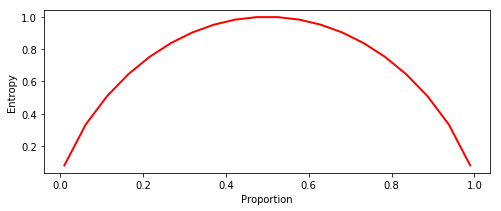

In [3]:
# graphical representation
fig = figure()
x = np.linspace(0.01,0.99,20)
y = -x * np.log2(x) - (1-x)*np.log2(1-x)
plt.xlabel('Proportion')
plt.ylabel('Entropy')
plt.plot(x,y,color='red',lw=2)
fig.set_size_inches(8,3)

<h3><font color='blue'>=======================================</font></h3>
<br>
<h3>Let us set up - pylab inlne and import the required libraries</h3>
<br>
<h3><font color='blue'>========================================</font></h3>

In [4]:
# Lets import the various libraries we are going to use in this exercise
%pylab inline
import numpy as np
import urllib

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


Populating the interactive namespace from numpy and matplotlib


<h3><font color='blue'>=======================================</font></h3>

<h3>Let us load the data, look at the sample, see the features, the target</h3>
<h3>The features are a mix of categorical and numerical - lets see examples of both</h3>

<h3><font color='blue'>=======================================</font></h3>

In [5]:
# Lets load the file using pandas and look at the first few rows
credit = pd.read_csv('credit.csv')
credit.head()
# credit.describe()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes


In [6]:
credit.describe()

,months_loan_duration,amount,percent_of_income,years_at_residence,age,existing_loans_count,dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [7]:
# Use value counts to see dispersion of checking_balance classes
credit.checking_balance.value_counts()

unknown       394
< 0 DM        274
1 - 200 DM    269
> 200 DM       63
Name: checking_balance, dtype: int64

In [8]:
# Use describe to see the savings_balance classes
credit.savings_balance.describe()

count         1000
unique           5
top       < 100 DM
freq           603
Name: savings_balance, dtype: object

In [9]:
credit.savings_balance.value_counts()

< 100 DM         603
unknown          183
100 - 500 DM     103
500 - 1000 DM     63
> 1000 DM         48
Name: savings_balance, dtype: int64

In [10]:
# See the description for a numerical, continuous variable
credit.amount.describe()

count     1000.000000
mean      3271.258000
std       2822.736876
min        250.000000
25%       1365.500000
50%       2319.500000
75%       3972.250000
max      18424.000000
Name: amount, dtype: float64

In [11]:
# Lets take a look at the result variable
credit.default.describe()

count     1000
unique       2
top         no
freq       700
Name: default, dtype: object

In [12]:
credit.default.value_counts()

no     700
yes    300
Name: default, dtype: int64

<h3><font color='blue'>=======================================</font></h3>
<h4>
We have the credit dataframe which has some nominal columns. Scikit machine lerning requires numerical values across. We will use the following scheme to attain our objective :
<br>
<ol>
<li>We will fit a label encoder to a column</li>
<li>Lets say we have a gender column which codes male as 'M' and female as 'F' - The fit method will find these two labels - and the transform will convert them into integer values - 0 and 1 - so the column will have all across instead of 'M' and 'F' - values 0 and 1</li>
<li>We have to go a step further and transform these into binary features - so that we can get rid of the artificial ordering implicit in integer values 0 and 1 - all 'M' > 'F' and 'F' > 'M' and 'F' = 'M' are meanignless in our context. We will use OneHotEncoder to transform these into binary features.</li>
<li>What the OneHotEncoder will give us back will be a sparse matrix which is a combination of two arrays - indices and values - so if a 100 x 100 matrix has values only in 30 of its cells - we have saved space for 970 values - while incurring the overhead of adding two arrays</li>
<li>We will in this instance convert the sparse matrix to an array - for savings_balance we will instead of 1 column have 5 columns - with values - either 0 or 1</li>
</ol>
</h4>

<h3><font color='blue'>=======================================</font></h3>

In [13]:
# Lets see the data types of the columns of the credit data frame 
print( [(x,dtype(credit[x])) for x in credit.columns] )

[('checking_balance', dtype('O')), ('months_loan_duration', dtype('int64')), ('credit_history', dtype('O')), ('purpose', dtype('O')), ('amount', dtype('int64')), ('savings_balance', dtype('O')), ('employment_duration', dtype('O')), ('percent_of_income', dtype('int64')), ('years_at_residence', dtype('int64')), ('age', dtype('int64')), ('other_credit', dtype('O')), ('housing', dtype('O')), ('existing_loans_count', dtype('int64')), ('job', dtype('O')), ('dependents', dtype('int64')), ('phone', dtype('O')), ('default', dtype('O'))]


In [14]:
# Explore label and one hot encoder
enc = LabelEncoder()
label_encoder = enc.fit(credit['savings_balance'])
print('label encoder classes ', label_encoder.classes_)
integer_classes = label_encoder.transform(label_encoder.classes_)
print('integer classes ', integer_classes, integer_classes.shape)
integer_classes = integer_classes.reshape( integer_classes.shape[0], 1)
transformed_data = label_encoder.transform(credit['savings_balance']).reshape(
credit['savings_balance'].shape[0],1)
print('original and label transformed data:\n',
      [x for x in zip(credit['savings_balance'].ix[:5], transformed_data[:5] )])
ohe = OneHotEncoder()
oheenc = ohe.fit(integer_classes)

ohe_tr_data = oheenc.transform(transformed_data)
ohe_tr_data.todense()[:5]

label encoder classes  ['100 - 500 DM' '500 - 1000 DM' '< 100 DM' '> 1000 DM' 'unknown']
integer classes  [0 1 2 3 4] (5,)
original and label transformed data:
 [('unknown', array([4], dtype=int64)), ('< 100 DM', array([2], dtype=int64)), ('< 100 DM', array([2], dtype=int64)), ('< 100 DM', array([2], dtype=int64)), ('< 100 DM', array([2], dtype=int64))]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


matrix([[ 0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.]])

In [15]:
# Let us initialize an empty data frame
credit_transformed = pd.DataFrame()
for x in credit.columns[:-1]:

    # convert all nominal columns into binary feature colums
    if dtype(credit[x]) == 'object':
        # Fit a label encoder
        enc = LabelEncoder()
        label_encoder = enc.fit(credit[x])
        # Transform the classes into integers
        integer_classes = label_encoder.transform(label_encoder.classes_)
        # reshape the integer_classes so that the one hot encoding fit will work
        integer_classes = integer_classes.reshape( integer_classes.shape[0],1)
        # transform the column data
        transformed_data = label_encoder.transform(credit[x]).reshape(
            credit[x].shape[0],1)
        # Initialize and fit a one hot encoder to the integer classes
        ohe = OneHotEncoder()
        oheEnc = ohe.fit(integer_classes)
        #  Now use the one hot encoder to transform the data that has only integer values
        ohe_tr_data = oheEnc.transform(transformed_data)
        # Concatenate to build up the credit dataframe
        credit_transformed = pd.concat([credit_transformed, pd.DataFrame(ohe_tr_data.toarray(),
                            columns=[x + '_' + y.strip().replace(' ','')
                            for y in label_encoder.classes_.tolist()])], axis=1)
#         print data_transformed_to_integer_classes
    else:
#         print 'numerical'
        credit_transformed[x] = credit[x]

credit_transformed['default'] = LabelEncoder().fit_transform(credit['default'])

print ('The original dataframe shape ' , credit.shape, ' and that ' \
       ' of the transformed  one', credit_transformed.shape )
print ( credit_transformed.iloc[:1] )

The original dataframe shape  (1000, 17)  and that  of the transformed  one (1000, 45)
   checking_balance_1-200DM  checking_balance_<0DM  checking_balance_>200DM  \
0                       0.0                    1.0                      0.0   

   checking_balance_unknown  months_loan_duration  credit_history_critical  \
0                       0.0                     6                      1.0   

   credit_history_good  credit_history_perfect  credit_history_poor  \
0                  0.0                     0.0                  0.0   

   credit_history_verygood   ...     housing_rent  existing_loans_count  \
0                      0.0   ...              0.0                     2   

   job_management  job_skilled  job_unemployed  job_unskilled  dependents  \
0             0.0          1.0             0.0            0.0           1   

   phone_no  phone_yes  default  
0       0.0        1.0        0  

[1 rows x 45 columns]


<h3><font color='blue'>=======================================</font></h3>
<h3>
Let us split the data and fit a DecisionTree Classifier on the training data
</h3>


<h3><font color='blue'>=======================================</font></h3>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


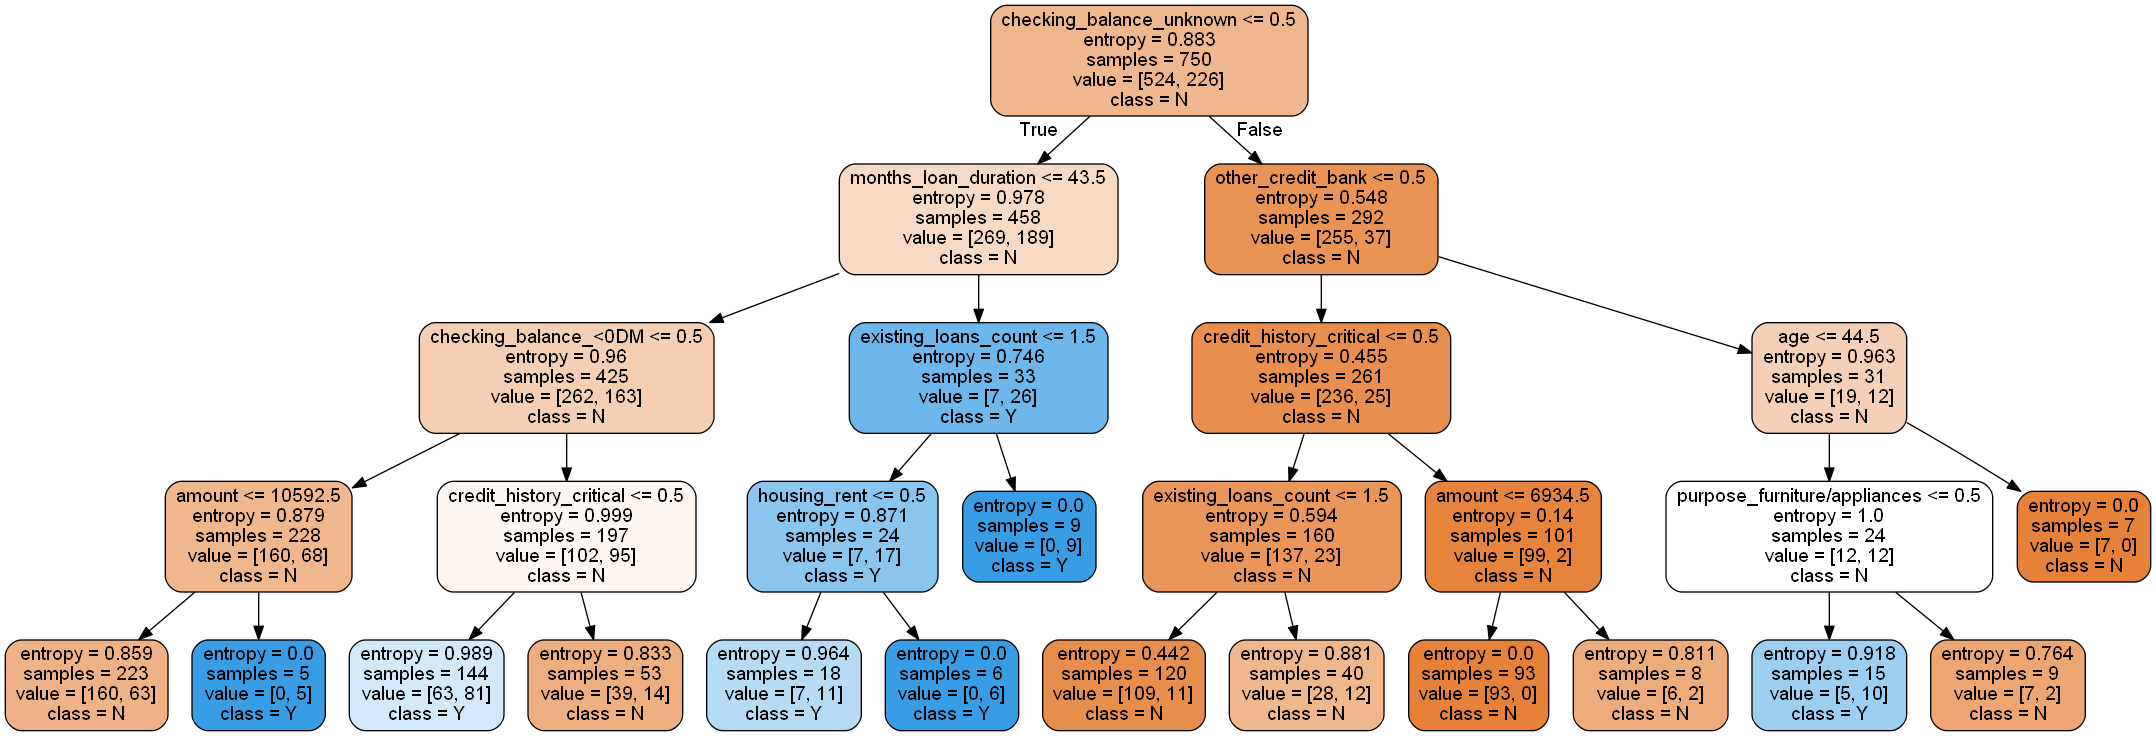

In [16]:
# To make the visualization work installed pydotplus and graphviz using conda
# However graphviz executable still could not be found
# One suggestion that pydotplus should be installed after graphviz so did conda uninstall and install pydotplus
# Next started the jupyter from the Anaconda dot prompt - did not work  - what worked was the following action
# Solution was to find the graphviz msi installer and add it to the path
X_train,X_test,y_train,y_test = train_test_split(
    credit_transformed.ix[:, credit_transformed.columns != 'default'], 
    credit_transformed['default'], random_state = 0 )
classifier = DecisionTreeClassifier(criterion='entropy', max_depth=4,
                                    min_samples_leaf=5, random_state=10)
classifier.fit(X_train,y_train)
collist = credit_transformed.columns.tolist()
collist.remove('default')

import pydotplus, io
dot_data = io.StringIO() 
tree.export_graphviz(classifier, out_file=dot_data, feature_names=collist,
                    filled=True, rounded=True, class_names=['N','Y'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png('german_credit.png') 
from IPython.core.display import Image 
Image(filename='german_credit.png')

<h3><font color='blue'>=======================================</font></h3>

<h3>
Understand how the decison tree is getting built
</h3>


<h3><font color='blue'>=======================================</font></h3>

In [17]:
# Formula to compute entropy
def computeEntropy(p1,p2):
    return -p1/(p1+p2) * np.log2(p1/(p1+p2)) - p2/(p1+p2) * np.log2(p2/(p1+p2))
print('%.4f' % computeEntropy(524,226) )
print('%.4f' % computeEntropy(700,300) )

0.8829
0.8813


In [18]:
X_train.columns

Index(['checking_balance_1-200DM', 'checking_balance_<0DM',
       'checking_balance_>200DM', 'checking_balance_unknown',
       'months_loan_duration', 'credit_history_critical',
       'credit_history_good', 'credit_history_perfect', 'credit_history_poor',
       'credit_history_verygood', 'purpose_business', 'purpose_car',
       'purpose_car0', 'purpose_education', 'purpose_furniture/appliances',
       'purpose_renovations', 'amount', 'savings_balance_100-500DM',
       'savings_balance_500-1000DM', 'savings_balance_<100DM',
       'savings_balance_>1000DM', 'savings_balance_unknown',
       'employment_duration_1-4years', 'employment_duration_4-7years',
       'employment_duration_<1year', 'employment_duration_>7years',
       'employment_duration_unemployed', 'percent_of_income',
       'years_at_residence', 'age', 'other_credit_bank', 'other_credit_none',
       'other_credit_store', 'housing_other', 'housing_own', 'housing_rent',
       'existing_loans_count', 'job_management'

In [32]:
 # We take any column 
cname = 'credit_history_critical'
# we compute the base level entropy using y_train
bcounts = np.bincount(y_train)
print(bcounts)
bentropy =  computeEntropy(bcounts[0], bcounts[1])
print('Entropy at base level {:.4f}'.format(bentropy))
# We compute the new entropy using the partitions that are created by the split
# for convenience we check the binary columns
# find indices where value is zero
zindices = X_train[X_train[cname] == 0].index
# Then within the first partitioin we see how many are no -0 and yes - 1 
p1vals = np.bincount(y_train[zindices])
# find indices where value is one
yindices = X_train[X_train[cname] == 1].index
# Within the second partition how many are no - 0 and yes - 1
p2vals = np.bincount(y_train[yindices])
# we compute entropy for the two partitions
p1entropy = computeEntropy(p1vals[0], p1vals[1])
p2entropy = computeEntropy(p2vals[0], p2vals[1])
print('Partition 1 entropy {:.4f}, Partition 2 entropy {:.4f}'.format(p1entropy, p2entropy))
# we compute weighted entropy for the two partitions that are created
nl_entropy = (p1entropy * p1vals.sum() + p2entropy * p2vals.sum())/(p1vals.sum()+p2vals.sum())
print('New level entropy {0: .4f}'.format(nl_entropy))
# we examine the information gain that is produced
print('Decr in impurity or IG  {:.4f}'.format(bentropy - nl_entropy))

[524 226]
Entropy at base level 0.8829
Partition 1 entropy 0.9395, Partition 2 entropy 0.6653
New level entropy  0.8572
Decr in impurity or IG  0.0257


In [33]:
 # we create a function to find out the information gain given base level partition
# and the two split partitions under it
l1s = np.array([269, 189])
l2p1s = np.array([262, 163])
l2p2s = np.array([7, 26])
def IG_Across_level(l1, l2p1, l2p2):
    l1fv = l1[0]
    l1sv = l1[1]
    l1_entropy = computeEntropy(l1[0], l1[1])
    print(l1_entropy)
    l2p1sum = l2p1.sum()
    l2p2sum = l2p2.sum()
    l2p1_entropy = computeEntropy(l2p1[0], l2p1[1])
    l2p2_entropy = computeEntropy(l2p2[0], l2p2[1])
    print(l2p1_entropy,l2p2_entropy)
    l2p_entropy = (l2p1sum * l2p1_entropy + l2p2sum * l2p2_entropy ) / (l2p1sum + l2p2sum)
    print(l2p_entropy)
    return l1_entropy - l2p_entropy
IG_Across_level(l1s, l2p1s, l2p2s)

0.977878037648
0.960496641513 0.745517842811
0.945006902742


0.032871134906012456

<h3><font color='blue'>=======================================</font></h3>

<h3>
Let us see the predictions and the performance
</h3>


<h3><font color='blue'>=======================================</font></h3>

In [34]:
predictions = classifier.predict(X_test)
predictions_proba = classifier.predict_proba(X_test)

In [35]:
classifier.apply(X_test)
# X_test.iloc[0,:]

array([ 7, 17, 17,  4, 17, 17,  4, 17, 17, 11,  4,  7,  4,  7,  4, 17,  7,
       26,  7,  4,  7,  4, 11, 17, 20, 11, 20,  4, 20, 11,  8, 25, 17,  4,
       17,  5,  4, 20,  7, 17,  4,  7, 26, 20,  4,  4,  7,  4,  7,  7, 20,
       11,  8,  8,  7, 17, 11, 17, 17,  7, 11, 20,  7, 18, 17, 20, 20,  4,
        4,  4, 20,  4,  7, 24,  8, 20, 18,  7,  4, 20,  7,  8, 17,  4,  4,
        8,  5,  7, 20,  7, 18,  8,  4, 17, 17,  4, 13,  7,  7,  8,  4, 17,
       18, 21,  4, 17,  4,  8,  7, 20,  4,  4,  7, 17, 11, 20,  7, 17, 17,
        4,  4, 17, 17,  7,  4, 26, 20, 20, 20, 17,  7,  7,  7,  8, 20,  7,
        4, 17,  7,  7,  4, 11, 20, 17, 17,  4, 18,  5,  4,  4, 20,  4, 18,
        4,  4, 20,  7,  4, 20, 18,  4,  4, 17, 25, 13,  5,  4, 17,  4, 24,
       13, 17, 11,  8, 20,  7,  7,  4,  4, 20, 17, 11, 25,  7,  4,  7, 17,
        7, 26, 20,  4, 13,  4, 17, 20, 17,  7,  4,  4, 25,  4,  7, 11,  4,
       20,  4, 11,  8,  7, 17, 21,  7,  4, 20, 17,  7,  4,  4, 25,  7,  7,
       24,  4, 20, 20, 26

In [36]:
clf = classifier
# we can zip the feature, threshold, left and right children to get a concise summation of 
# the tree structure
tzip = zip(X_train.columns[clf.tree_.feature],
           clf.tree_.threshold, clf.tree_.children_left, clf.tree_.children_right,
          clf.tree_.compute_feature_importances(normalize=False)[clf.tree_.feature])
[x for x in tzip]

[('checking_balance_unknown', 0.5, 1, 14, 0.072265305623207085),
 ('months_loan_duration', 43.5, 2, 9, 0.020073306382604964),
 ('checking_balance_<0DM', 0.5, 3, 6, 0.014596769386988057),
 ('amount', 10592.5, 4, 5, 0.022136315862908901),
 ('phone_no', -2.0, -1, -1, 0.0),
 ('phone_no', -2.0, -1, -1, 0.0),
 ('credit_history_critical', 0.5, 7, 8, 0.026634358444356371),
 ('phone_no', -2.0, -1, -1, 0.0),
 ('phone_no', -2.0, -1, -1, 0.0),
 ('existing_loans_count', 1.5, 10, 13, 0.013926464188837912),
 ('housing_rent', 0.5, 11, 12, 0.0047297726601341688),
 ('phone_no', -2.0, -1, -1, 0.0),
 ('phone_no', -2.0, -1, -1, 0.0),
 ('phone_no', -2.0, -1, -1, 0.0),
 ('other_credit_bank', 0.5, 15, 22, 0.015180875595728992),
 ('credit_history_critical', 0.5, 16, 19, 0.026634358444356371),
 ('existing_loans_count', 1.5, 17, 18, 0.013926464188837912),
 ('phone_no', -2.0, -1, -1, 0.0),
 ('phone_no', -2.0, -1, -1, 0.0),
 ('amount', 6934.5, 20, 21, 0.022136315862908901),
 ('phone_no', -2.0, -1, -1, 0.0),
 ('pho

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print ( accuracy_score(y_test,predictions)  )
print ( confusion_matrix(y_test,predictions) )
print (  classification_report(y_test,predictions)  )

0.708
[[140  36]
 [ 37  37]]
             precision    recall  f1-score   support

          0       0.79      0.80      0.79       176
          1       0.51      0.50      0.50        74

avg / total       0.71      0.71      0.71       250



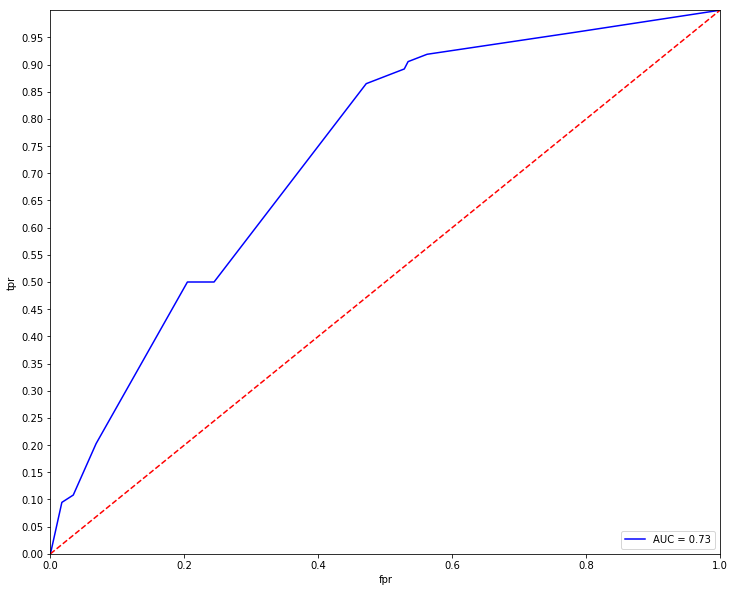

In [39]:
from sklearn.metrics import roc_curve, auc
fpr, recall, thlds = roc_curve(y_test, predictions_proba[:,1])
fig = figure()
auc_dt = auc(fpr, recall)
plt.plot(fpr, recall, 'b', label='AUC = %.2f'%auc_dt)
plt.legend(loc ='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.yticks(np.arange(0.0, 1.0, 0.05))
fig.set_size_inches(12, 10)

In [47]:
print([x for x in zip (fpr, recall, thlds)])
# roc_curve? 

[(0.0, 0.0, 2.0), (0.017045454545454544, 0.0945945945945946, 1.0), (0.034090909090909088, 0.10810810810810811, 0.66666666666666663), (0.068181818181818177, 0.20270270270270271, 0.61111111111111116), (0.20454545454545456, 0.5, 0.5625), (0.24431818181818182, 0.5, 0.29999999999999999), (0.47159090909090912, 0.86486486486486491, 0.28251121076233182), (0.52840909090909094, 0.89189189189189189, 0.26415094339622641), (0.53409090909090906, 0.90540540540540537, 0.25), (0.5625, 0.91891891891891897, 0.22222222222222221), (0.78409090909090906, 0.95945945945945943, 0.09166666666666666), (1.0, 1.0, 0.0)]


In [48]:
# Let us undrestand the roc workings further
probs = classifier.predict_proba(X_test)
print('Type of probs ', type(probs), ' and shape of probs ', probs.shape)
plength = probs.shape[0]
probs_ext = np.concatenate( (probs, np.zeros(plength).reshape(plength, 1)), axis=1)
print('probs_ext with a zero column appended shape ', probs_ext.shape)
thold = 0.29999
probs_ext[:, 2] = np.where(probs_ext[:,1]>thold, 1,0)
print('prob_ext sample after setting values greater than threshold to 1\n', probs_ext[:10])
np.bincount(probs_ext.astype(int)[:,2])
thold_predictions = probs_ext[:,2]
act_and_thold_predict = list(zip(y_test, thold_predictions))
act_0_pred_0 = len([x for x in act_and_thold_predict if x[0] == 0 and x[1] == 0])
print('actual 0 and predicted 0 TNs ', act_0_pred_0)
act_0_pred_1 = len([x for x in act_and_thold_predict if x[0] == 0 and x[1] == 1 ])
print('actual 0 and predicted 1 FPs', act_0_pred_1)
act_1_pred_0 = len([x for x in act_and_thold_predict if x[0] == 1 and x[1] == 0])
print('actual 1 and predicted 0 FNs', act_1_pred_0)
act_1_pred_1 = len([x for x in act_and_thold_predict if x[0] == 1 and x[1] == 1 ])
print('actual 1 and predicted 1 TPs ', act_1_pred_1)

Type of probs  <class 'numpy.ndarray'>  and shape of probs  (250, 2)
probs_ext with a zero column appended shape  (250, 3)
prob_ext sample after setting values greater than threshold to 1
 [[ 0.4375      0.5625      1.        ]
 [ 0.90833333  0.09166667  0.        ]
 [ 0.90833333  0.09166667  0.        ]
 [ 0.71748879  0.28251121  0.        ]
 [ 0.90833333  0.09166667  0.        ]
 [ 0.90833333  0.09166667  0.        ]
 [ 0.71748879  0.28251121  0.        ]
 [ 0.90833333  0.09166667  0.        ]
 [ 0.90833333  0.09166667  0.        ]
 [ 0.38888889  0.61111111  1.        ]]
actual 0 and predicted 0 TNs  133
actual 0 and predicted 1 FPs 43
actual 1 and predicted 0 FNs 37
actual 1 and predicted 1 TPs  37


In [49]:
X_train.ix[(X_train['checking_balance_unknown']==0) &
          (X_train['months_loan_duration']<=43.5)
          &(X_train['checking_balance_<0DM'] == 0) & (X_train['amount'] <= 10592.5)].shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


(223, 44)

In [50]:
tidxs = X_train.ix[(X_train['checking_balance_unknown']==0) &
          (X_train['months_loan_duration']<=43.5)
          &(X_train['checking_balance_<0DM'] == 0) & (X_train['amount'] >= 10592.5)].index
y_train[tidxs]

105    1
563    1
381    1
431    1
87     1
Name: default, dtype: int64

In [51]:
X_train.ix[(X_train['checking_balance_unknown']==0) &
          (X_train['months_loan_duration']<=43.5)
          &(X_train['checking_balance_<0DM'] != 0) 
           & (X_train['credit_history_critical'] == 0)
          ].shape

(144, 44)

In [69]:
# The decision estimator has an attribute called tree_  which stores the entire
# tree structure and allows access to low level attributes. The binary tree
# tree_ is represented as a number of parallel arrays. The i-th element of each
# array holds information about the node `i`. Node 0 is the tree's root. NOTE:
# Some of the arrays only apply to either leaves or split nodes, resp. In this
# case the values of nodes of the other type are arbitrary!
#
# Among those arrays, we have:
#   - left_child, id of the left child of the node
#   - right_child, id of the right child of the node
#   - feature, feature used for splitting the node
#   - threshold, threshold value at the node
#

# Using those arrays, we can parse the tree structure:
estimator = classifier
n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold

print('n_nodes\n',n_nodes,'\nchildren_left\n',children_left,
      '\nchildren_right\n',children_right,'\nfeature\n',feature,'\nthreshold\n',threshold)
# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (int(node_depth[i]) * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (int(node_depth[i]) * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()


n_nodes
 27 
children_left
 [ 1  2  3  4 -1 -1  7 -1 -1 10 11 -1 -1 -1 15 16 17 -1 -1 20 -1 -1 23 24 -1
 -1 -1] 
children_right
 [14  9  6  5 -1 -1  8 -1 -1 13 12 -1 -1 -1 22 19 18 -1 -1 21 -1 -1 26 25 -1
 -1 -1] 
feature
 [ 3  4  1 16 -2 -2  5 -2 -2 36 35 -2 -2 -2 30  5 36 -2 -2 16 -2 -2 29 14 -2
 -2 -2] 
threshold
 [  5.00000000e-01   4.35000000e+01   5.00000000e-01   1.05925000e+04
  -2.00000000e+00  -2.00000000e+00   5.00000000e-01  -2.00000000e+00
  -2.00000000e+00   1.50000000e+00   5.00000000e-01  -2.00000000e+00
  -2.00000000e+00  -2.00000000e+00   5.00000000e-01   5.00000000e-01
   1.50000000e+00  -2.00000000e+00  -2.00000000e+00   6.93450000e+03
  -2.00000000e+00  -2.00000000e+00   4.45000000e+01   5.00000000e-01
  -2.00000000e+00  -2.00000000e+00  -2.00000000e+00]
The binary tree structure has 27 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 3] <= 0.5 else to node 14.
	node=1 test node: go to node 2 if X[:, 4] <= 43.5 else to node 9.
		no

<h3><font color='blue'>=======================================</font></h3>

We will use the scikit learn pipeline infrastructure to check out various combinations of parameters.
<h3>
</h3>
Instead of manually runnng different combinations, pipelie allows us to specify a series of steps to run on different combinations of parameters. We can also specify the scoring parameter basis which the pipeline should evaluate model performance

<h3><font color='blue'>=======================================</font></h3>

In [70]:
pipeline = Pipeline([
        ('clf',DecisionTreeClassifier())
    ])
parameters = {
    'clf__criterion' :('gini','entropy'),
    'clf__min_samples_leaf' : (3,4,5),
    'clf__min_samples_split' : (3,4,5),
    'clf__max_depth' : (3,4,5,6,7,8,9)
    }
grid_search = GridSearchCV( pipeline, parameters, verbose=1)
grid_search.fit(X_train,y_train)
print (  'Best score %0.3f' % grid_search.best_score_   )
print  ( 'Best parameters set: ' )
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted( parameters.keys()):
    print (  param_name,best_parameters[param_name] , '\n' )
predictions_gs = grid_search.predict(X_test)
print  ( classification_report(y_test,predictions_gs) )

Fitting 3 folds for each of 126 candidates, totalling 378 fits
Best score 0.729
Best parameters set: 
clf__criterion gini 

clf__max_depth 6 

clf__min_samples_leaf 5 

clf__min_samples_split 4 

             precision    recall  f1-score   support

          0       0.78      0.78      0.78       176
          1       0.47      0.46      0.47        74

avg / total       0.69      0.69      0.69       250



[Parallel(n_jobs=1)]: Done 378 out of 378 | elapsed:    2.4s finished


<h3><font color='blue'>=======================================</font></h3>
<h4>Lets use feature selection to limit the features and run our classifier</h4>
<h4>We will use the chi square staistic in the feature selection initialization to limit the number of features to some low percentile and see the effect on our predictions</h4>
<h3><font color='blue'>=======================================</font></h3>

In [71]:

from sklearn import feature_selection
fs = feature_selection.SelectPercentile( feature_selection.chi2, percentile = 30)
X_train_fs = fs.fit_transform( X_train, y_train)
print  ( X_train_fs.shape )
print(fs.pvalues_)

(750, 13)
[  2.01908050e-02   1.96059863e-10   4.20124534e-02   7.86119366e-11
   2.83766595e-50   2.85805880e-05   6.45110865e-01   1.92709408e-06
   9.76030323e-01   1.01451354e-05   1.48612939e-01   8.86657460e-01
   2.68091990e-01   1.24098710e-01   1.37467510e-01   4.18179902e-01
   0.00000000e+00   2.69567210e-01   1.60243903e-01   1.59655275e-02
   5.39699474e-02   7.78234611e-04   8.66523673e-01   1.82079409e-01
   3.20044455e-04   9.85974503e-02   8.86328718e-01   2.09597514e-01
   8.13620663e-01   6.36865039e-06   1.78697677e-02   1.90426534e-01
   1.23852958e-01   2.33126779e-01   4.72315669e-02   2.08673823e-03
   5.78224785e-01   1.54527287e-01   3.76631356e-01   8.27579814e-01
   6.57649495e-01   7.35289645e-01   4.41154888e-01   3.58805438e-01]


In [87]:
fs_columns = credit_transformed.columns[:44][fs.get_support()]

In [88]:
classifier.fit(X_train_fs,y_train)
X_test_fs = fs.transform(X_test)
y_pred_fs = classifier.predict(X_test_fs)
print ( accuracy_score(y_test,y_pred_fs) )
print ( confusion_matrix(y_test,y_pred_fs) )
print ( classification_report(y_test,y_pred_fs) )

0.7
[[138  38]
 [ 37  37]]
             precision    recall  f1-score   support

          0       0.79      0.78      0.79       176
          1       0.49      0.50      0.50        74

avg / total       0.70      0.70      0.70       250



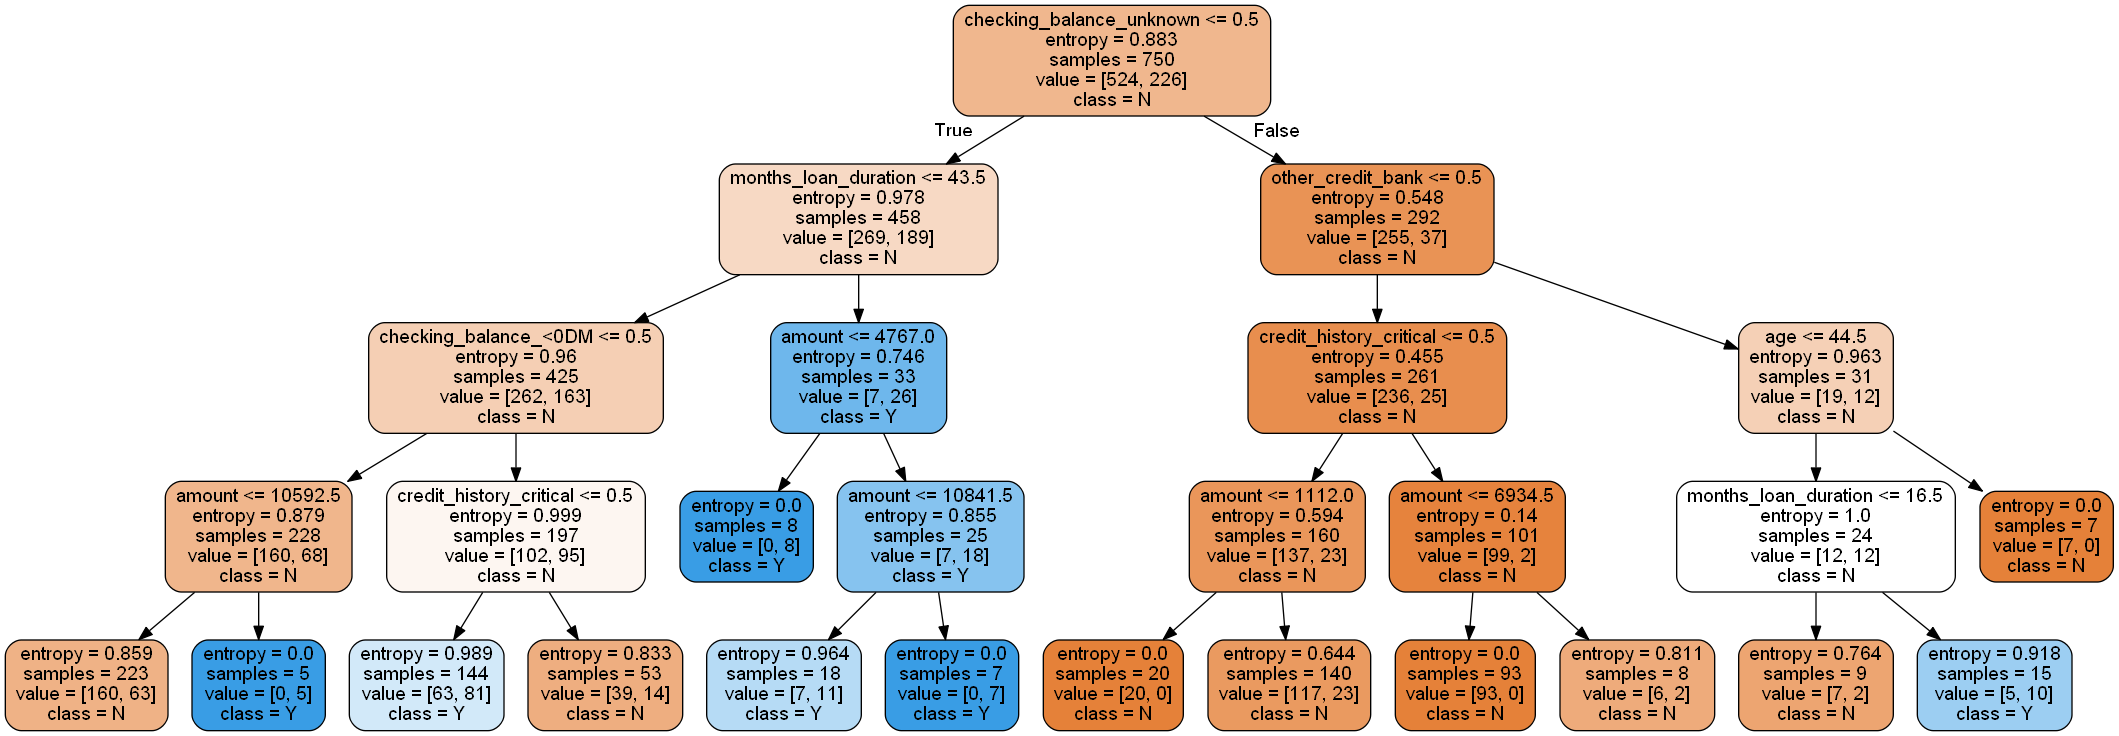

In [90]:
collist = credit_transformed.columns.tolist()
collist.remove('default')

import pydotplus,io
dot_data = io.StringIO() 
tree.export_graphviz(classifier, out_file=dot_data, feature_names=fs_columns, 
        class_names=['N','Y'],filled=True,rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png('german_credit_reduced.png') 
from IPython.core.display import Image 
Image(filename='german_credit_reduced.png')

In [91]:
from sklearn.ensemble import RandomForestClassifier
clf_rfc = RandomForestClassifier(n_estimators=10,random_state=100,max_depth=4)
rfcmodel = clf_rfc.fit(X_train,y_train)

In [92]:
rfcmodel.estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=186422792, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=735107864, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fracti

In [93]:
rfdt0 = rfcmodel.estimators_[0]
rfdt0.tree_.children_left
print(rfdt0.tree_.threshold)
rfdt1 = rfcmodel.estimators_[1]
print(rfdt1.tree_.threshold)

[  0.5   0.5   0.5   0.5  -2.   -2.    0.5  -2.   -2.    2.5   0.5  -2.
  -2.   64.   -2.   -2.    0.5   0.5   0.5  -2.   -2.    2.5  -2.   -2.
  -2. ]
[ 0.5  0.5  0.5  0.5 -2.  -2.   0.5 -2.  -2.   0.5  0.5 -2.  -2.   0.5 -2.
 -2.   1.5  0.5 -2.   0.5 -2.  -2.   0.5 -2.   0.5 -2.  -2. ]


In [94]:
rfcpredictions = rfcmodel.predict(X_test)

In [95]:
accuracy_score(rfcpredictions,y_test)

0.72399999999999998

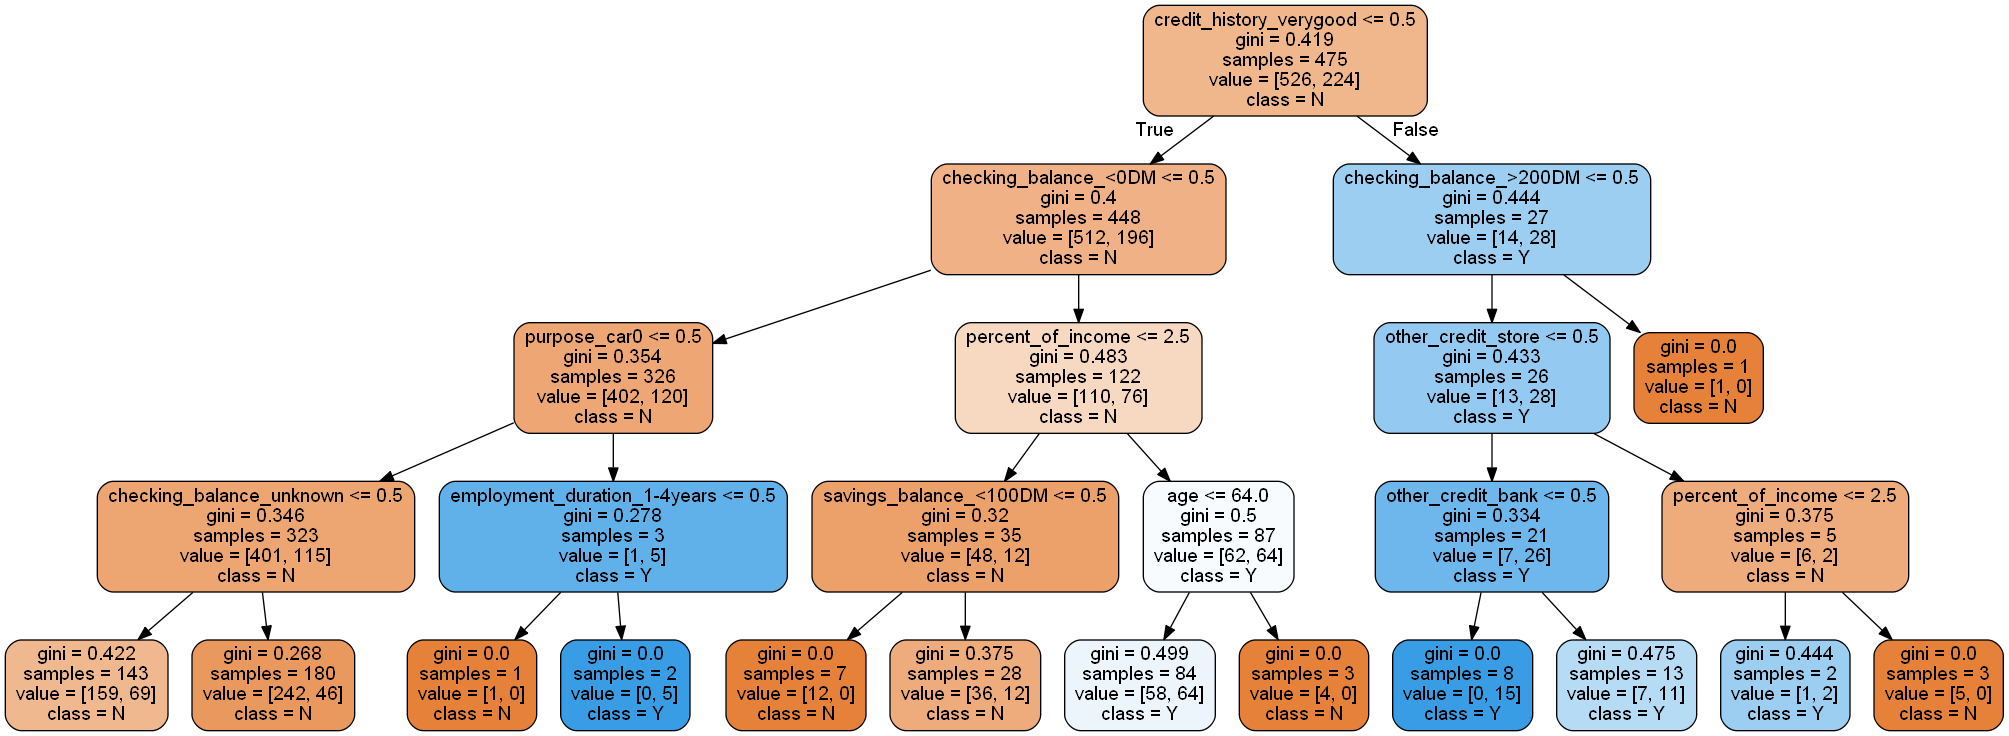

In [96]:
collist = credit_transformed.columns.tolist()
collist.remove('default')

import pydotplus,io
dot_data = io.StringIO() 
tree.export_graphviz(rfdt0, out_file=dot_data, feature_names=collist,
        class_names=['N','Y'],filled=True,rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png('rfdt0.png') 
from IPython.core.display import Image 
Image(filename='rfdt0.png')

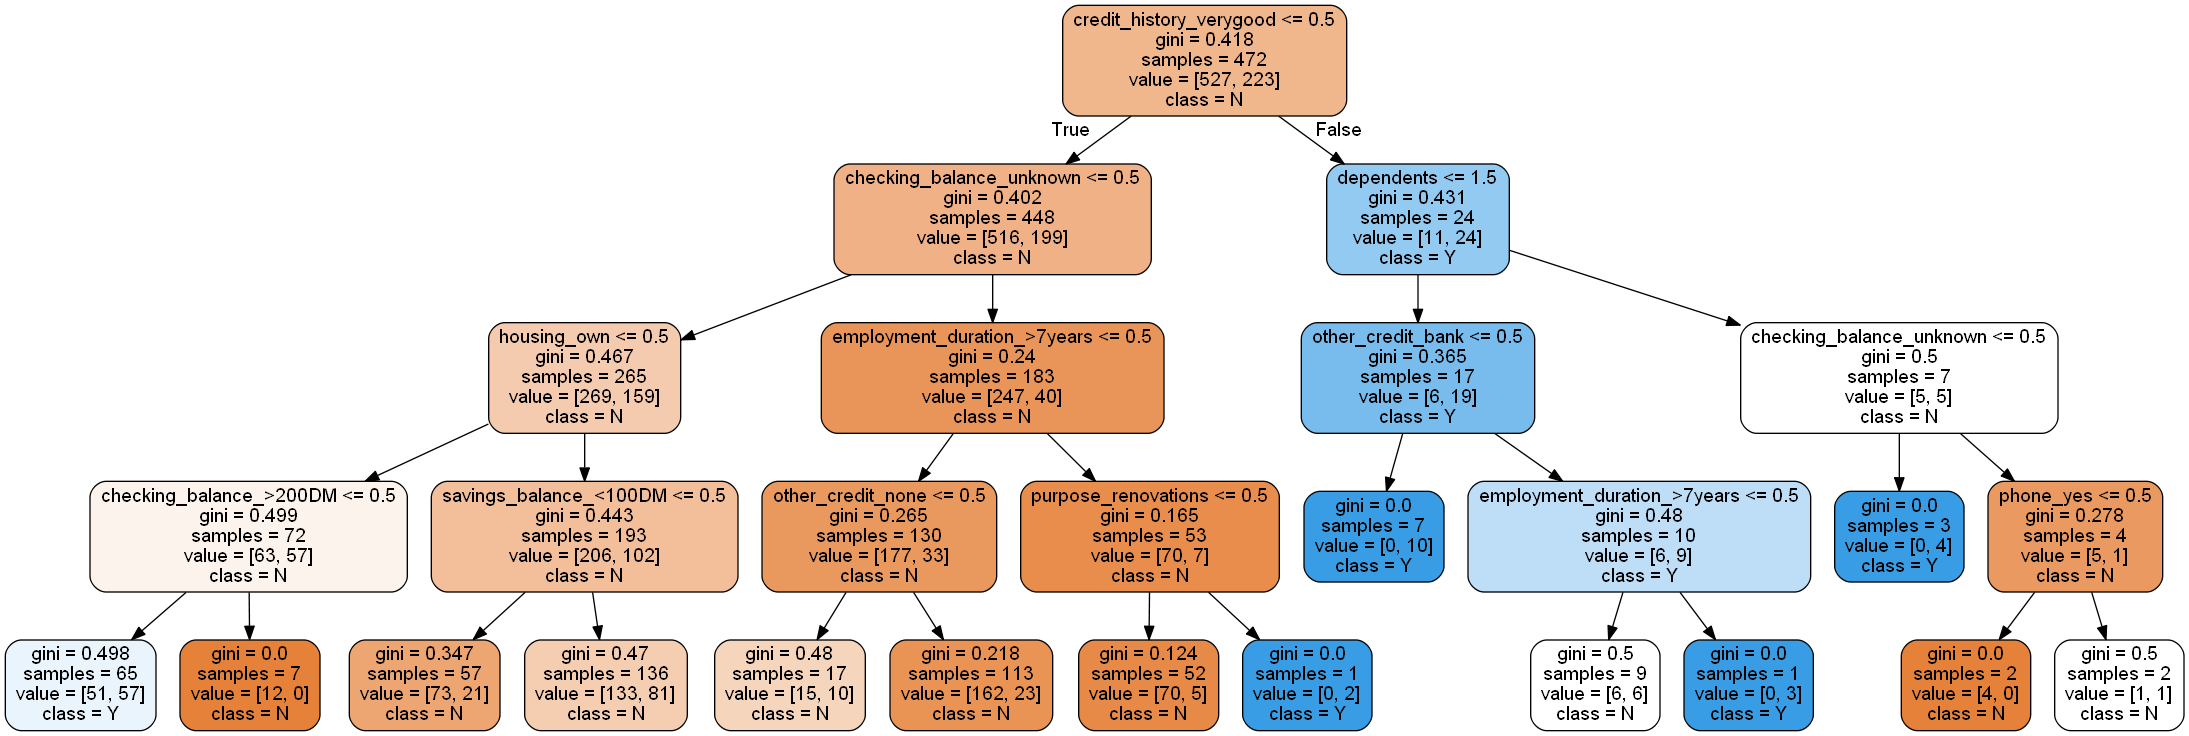

In [97]:
import pydotplus,io
dot_data = io.StringIO() 
tree.export_graphviz(rfdt1, out_file=dot_data, feature_names=collist,
        class_names=['N','Y'],filled=True,rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png('rfdt1.png') 
from IPython.core.display import Image 
Image(filename='rfdt1.png')

In [99]:
rfc_pipeline = Pipeline([
        ('clf',RandomForestClassifier())
    ])
rfc_parameters = {
    'clf__criterion' : ('entropy','gini'),
     'clf__min_samples_leaf' : (2, 3, 4, 5),
    'clf__min_samples_split' : (2, 3, 4, 5),
    'clf__max_depth' : (2, 3, 4, 5, 6, 7, 8, 9)
    }
grid_search = GridSearchCV(rfc_pipeline, rfc_parameters, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)
print ( 'Best score %0.3f' % grid_search.best_score_   )
print  ('Best parameters set: ' )
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted( rfc_parameters.keys()):
    print ( param_name,best_parameters[param_name] , '\n' )
predictions = grid_search.predict(X_test)
print  (classification_report(y_test, predictions) )

Fitting 3 folds for each of 256 candidates, totalling 768 fits
Best score 0.760
Best parameters set: 
clf__criterion gini 

clf__max_depth 7 

clf__min_samples_leaf 2 

clf__min_samples_split 5 

             precision    recall  f1-score   support

          0       0.76      0.91      0.83       176
          1       0.59      0.31      0.41        74

avg / total       0.71      0.73      0.70       250



[Parallel(n_jobs=1)]: Done 768 out of 768 | elapsed:   14.7s finished
